# Introduction

Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

## About the data

The dataset you will be working with is called Emo-DB and can be found [here](http://emodb.bilderbar.info/index-1280.html).

It is a database containing samples of emotional speech in German. It contains samples labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information")
   
The goal of this project is to develop a model which is able to **classify samples of emotional speech**. Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!

## Deliverable

The end-goal is to deliver us a zip file containing:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work
* A Dockerfile which defines a container for the project. The container should handle everything (download the data, run the code, etc...). When running the container it should expose the jupyter notebook on one port and expose a Flask API on another one. The Flask app contains two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* A README.md which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* Any necessary .py, .sh or other files needed to run your code.

# Report 
## Author : Segatto Pier Luigi

The use case proposed consists in dockerizing a web app whose API has been built to either train a model or predict from that trained model. The framework used for the backend API is Flask. 

The model objective is to learn how to recognize emotions based on a voice audio sample. Particularly, the model will be trained using the Emo-DB dataset. This audio collection is a database of emotional utterances spoken by actors. The recordings took place in the anechoic chamber of the Technical University Berlin, department of Technical Acoustics. 

I implemented the state-of-the-art model for sentiment emotion recognition illustrated in [Issa et al. 2020](https://www.sciencedirect.com/science/article/abs/pii/S1746809420300501?via%3Dihub): Speech emotion recognition with deep convolutional neural networks. The proposed model uses a convolutional neural network (CNN) for the classification of emotions based on features extracted from a sound file. The model includes one-dimensional convolutional layers combined with dropout, batch normalization, and activation layers. 

# Libraries Loading

In [85]:
import IPython
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from collections import Counter

# tensorflow
from tensorflow import keras
# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D

# my modules
from data.data_reader import get_dataset, get_labels, get_maps, augment_sample, create_train_test_sets
from model.network_model import plot_emotion_confusion_matrix, run_best_model_or_train_model

%matplotlib inline

# Data Preparation & Cleaning

Data download is handled at container startup. Data processing, i.e. data reading, augmentation and creation of training and test sets, is performed only once when querying the train endpoint (as the features dataset is cached as .csv for future needs). On successive calls of this endpoint the entire process is substituted with the loading of the cached feature files. 

Here I show what this dataset contains, how features have been extracted, and how the train and test sets are shaped. Again, I followed the approach of the reference paper for the augmentation and features extraction techniques.

## Listening and visualizing the data

In [2]:
IPython.display.Audio("data/wav/03a01Fa.wav")

In [4]:
IPython.display.Audio("data/wav/03a04Nc.wav")

In [7]:
IPython.display.Audio("data/wav/09a02Eb.wav")

The audio file names are coded as follows:
- Positions 1-2: number of speaker
- Positions 3-5: code for text
- Position 6: emotion (sorry, letter stands for german emotion word)
- Position 7: if there are more than two versions these are numbered a, b, c ....

The possible emotions are the followings:
<img src="./report_files/pics/labels.png" alt="Emotions" width="800" height="600">

Whereas the pronounced sentences are:
<img src="./report_files/pics/sentences.png" alt="Sentences" width="800" height="700">

In [6]:
data, sampling_rate = librosa.load('data/wav/09a02Eb.wav')
print(f"Lenght of audio = {len(data)} ")
print(f"Sampling rate = {sampling_rate} Hz")

Lenght of audio = 33601
Sampling rate = 22050


Let's display the waveform and its spectrum.

In [15]:
def plot_spec(data,sampling_rate,title):
  fig, ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].set_ylabel('Amplitude')
  librosa.display.waveplot(data, sr=sampling_rate,ax=ax[0])
  ax[0].title.set_text(f'{title}')
  ax[1].specgram(data,Fs=2)  

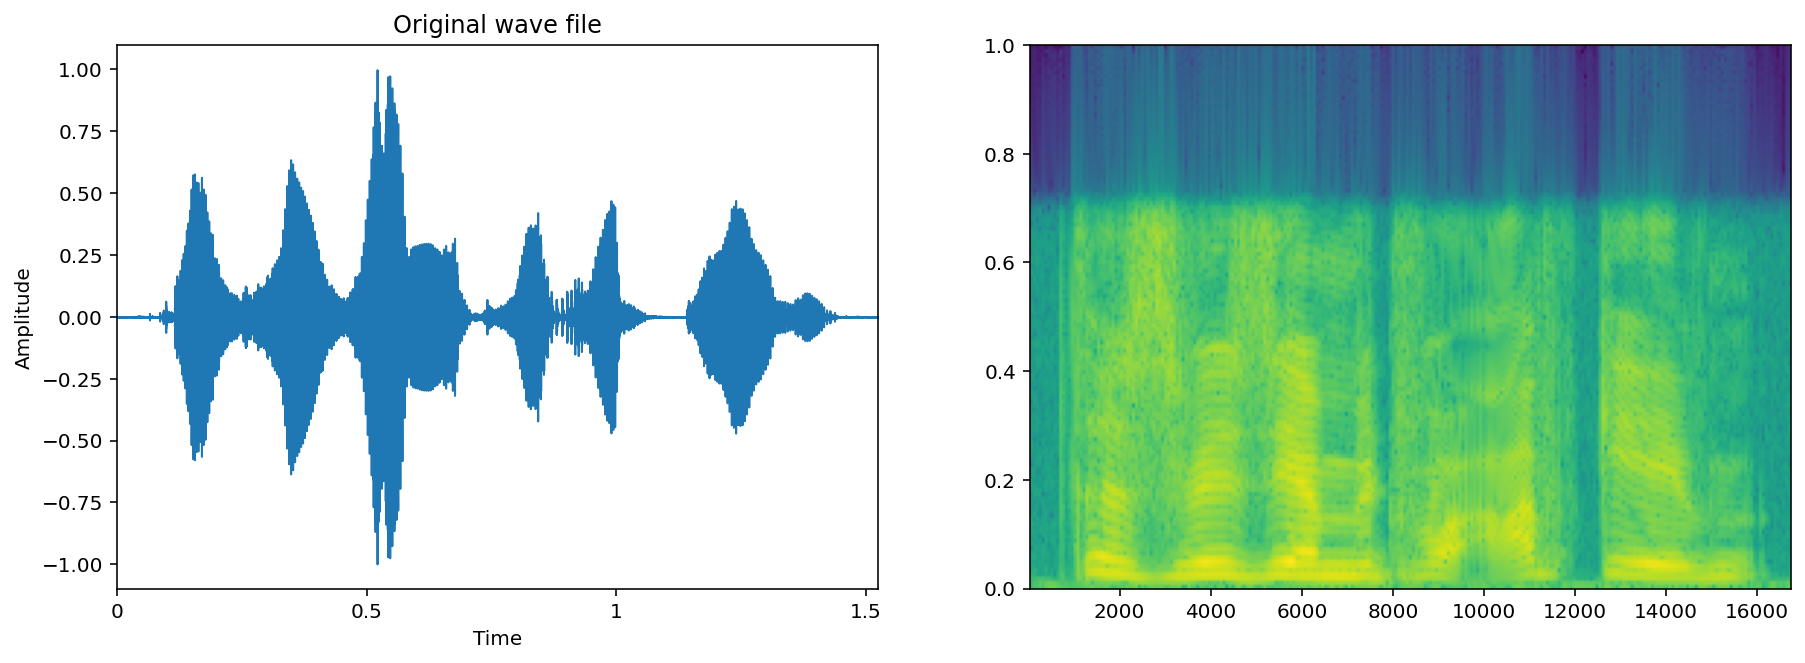

In [16]:
plot_spec(data,sampling_rate,'Original wave file')

The wave amplitude is normalized and the absence of background noise makes the audio rather clean. Low frequencies dominate the signal.

## Reading data

The API has been structured in order to preprocess the dataset, i.e. reading, augment, and dump to cache only when calling for the first time the /train endpoint. Subsequent calls to /train will use the cached feature and label files created after this first call.

When calling the /predict endpoint there is no need to reprocess data as they are either already present since a previous train request has been submitted or because the /predict endpoint is using the pretrained model and the backend script needs only to process the single file which has to be inferred.

In [27]:
# show the available emotions and the corresponding labels assigned for this project
map_0 = get_maps(from_='code', to_='label')
print(map_0)
map_1 = get_maps(from_='label', to_='emotion')
print(map_1)

{'W': 0, 'L': 1, 'E': 2, 'A': 3, 'F': 4, 'T': 5, 'N': 6}
{0: 'angry', 1: 'boredom', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'sad', 6: 'neutral'}


The emotions are extracted from the file name and to each sentiment an integer in 0-6 is associated which corresponds the label I am going to predict with the deep learning model.

In [35]:
# get names and labels
filenames, labels = get_labels(DATA_PATH='data/wav/')
print(f"Amount of raw audio files: {len(filenames)}")
print(filenames[:5])

Amount of raw audio files: 535
['data/wav/16a02Lb.wav', 'data/wav/14a07Wc.wav', 'data/wav/10a07Ad.wav', 'data/wav/13a05Ea.wav', 'data/wav/14a05Wa.wav']


In [36]:
labels[:5]

[1, 0, 3, 2, 0]

In [62]:
dist = Counter(labels)
dist

Counter({1: 81, 0: 127, 3: 69, 2: 46, 6: 79, 4: 71, 5: 62})

<BarContainer object of 7 artists>

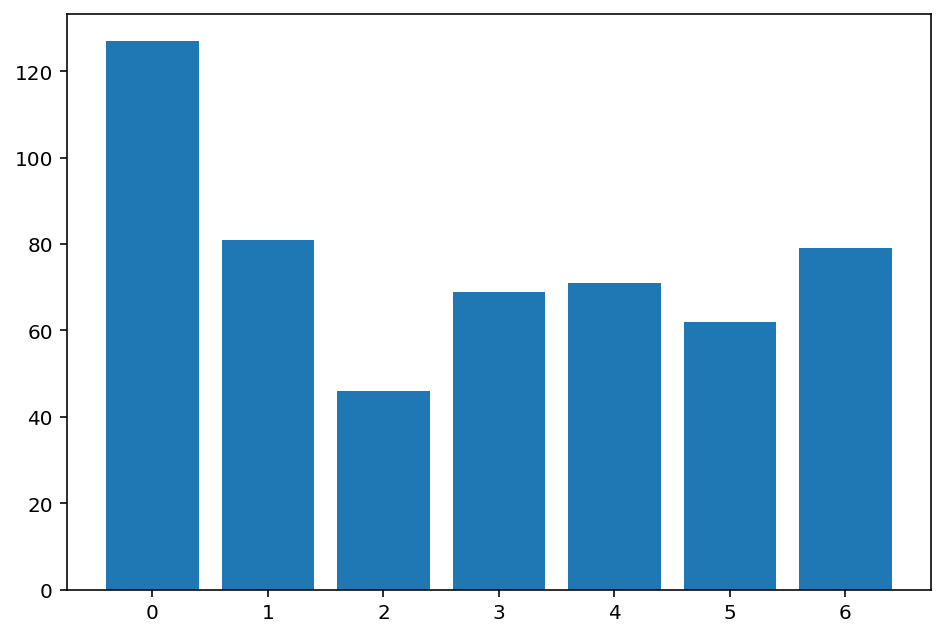

In [71]:
# Plotting the emotion distribution
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(dist.keys(),dist.values())

# Feature Engineering & Modeling

## Data augmentation

According to the reference paper, 535 audio files are not sufficient to guarantee an efficient training. I defined a function called **augment_sample** which produces n_modified (default = 3) versions of the input audio file. The sample is shifted, stretched and white noise is added. Audio files can also be saved.

As in the reference paper: *Our data augmentation techniques include alterations like moving the beginning of the sound file by some small amount,speeding up and slowing down the file by 1.23% and 0.81% of its normal speed, respectively, and adding random noise to the 25% of its length.*

In my approach:

- Shift is randomly chosen in the interval 0-6200 steps ~0.4 ms.

- Time stretch uses the same values suggested by the authors.

- I applied white noise to the entire audio signal. 

- I set default = 3 because it almost provides the same amount of training samples mentioned in issa et al., i.e. 2125. 

- Despite the reference paper I kept all raw audio samples (n=535) while the authors used n=425 samples but it does not appear clear how they got rid of them. 

In [42]:
# Show the process for a single audio file
file = "data/wav/09a02Eb.wav"
new_samples, label =augment_sample(file, n_modifications=3, dump=False, save_path='data/data_augment/')
print(f"Utterance: {map_1[label]}")

Utterance: disgust


In [46]:
# original
IPython.display.Audio(file, rate=sampling_rate)

In [47]:
IPython.display.Audio(new_samples[0], rate=sampling_rate)

In [48]:
IPython.display.Audio(new_samples[1], rate=sampling_rate)

In [49]:
IPython.display.Audio(new_samples[2], rate=sampling_rate)

## Feature Engineering  

Feature extraction is the main part of the speech emotion recognition system. It is basically accomplished by changing the speech waveform to a form of parametric representation at a relatively lesser data rate.

The input to the CNN consists in a concatenation (of lenght 193) of the following audio transformations

- Mel-frequency Cepstral Coefficients (MFCCs)
- Mel-scaled spectrogram
- Chromagram
- Spectral contrast feature
- Tonnetz representation

I report here the authors description of these features:

*Mel-scaled spectrogram and MFCCs are widely utilized in the field of sound classification and speech emotion recognition.These features mimic to a certain extent the reception pattern of sound frequency intrinsic to a human. In particular, MFCCs collectively make up the mel-frequency cepstrum, which is defined as the representation of the short-term power spectrum of a sound. The Fourier transform and the energy spectrum are obtained and mapped into the Mel-frequency scale. Although both Mel-scaled spectrogram and MFCCs are decent in identification and tracking of timbre fluctuations in a sound file, they tend to be poor in adistinguishable representation of pitch classes and harmony. Chromagrams are applied in order to deal with this problem. In this work, we used the obtained chromagram using short-time Fourier transform (STFT). The spectral contrast feature provides a more detailed spectral proof of a sound with respect to MFCCs and Mel-scaled spectrograms. According to the literature, methods based on detailed spectral information outperform techniques using Mel-scale in the field of music genre classification. The Tonnetz representation of a sound is similar to the chroma-grams with respect to the representation of harmony and pitchclasses. The method measures the tonal centroids of a sound in a six-dimensional pitch space called Tonal Centroid Space introduced by Harte et al. The tonal centroid is based on the Harmonic Network showing a planar representation of pitch relations such that pitch classes with close harmonic relations such as major/minor thirds have smaller Euclidean distances on theplane.*

I completely guessed the parameters required to get a 193-long vector.

## CNN Model

This is the baseline architecture presentented in the original paper:
<img src="./report_files/pics/model.png" alt="Model" width="700" height="700">

However, for the emo-DB dataset the authors suggest the following modifications:

*We make the following modifications to the baseline: elimination of batch normalization layer after the first dropout and after the fully connected layer, removal of two subsequent convolution layers after the max pooling, removal of convolution layer preceding the flattening layer, and elimination of dropout before the fully connected layer.

The final model that I implemented using the tensorflow framework is the following:

<img src="./report_files/pics/final_model.png" alt="Final Model" width="500" height="500">

The tensorflow implementation of the model is located in network_model.network_model, which I redefine here for clarity purposes. The code as it is creates the model for the emo-DB dataset. Uncomment all other layers to get the baseline model.

In [50]:
def network_model():
    """
    CNN model implemented in Dias Issa et al 2020 Speech emotion recognition
    with deep convolutional neural networks (Model A: model with 7 classes).
    """

    # Define architectural params
    n_classes = 7
    stride = 1
    kernel_size = 5

    # New model
    model = Sequential()
    # The first layer of our CNN receives 193 × 1 number arrays as input data
    # The initial layer iscomposed of 256 filters with the kernel size of 5 × 5 and stride 1.
    model.add(Conv1D(filters=256, kernel_size=kernel_size, strides=stride,
                     padding='same', input_shape=(193, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(filters=128, kernel_size=kernel_size, strides=stride,
                     padding='same'))
    model.add(Activation('relu'))

    model.add(Dropout(0.1))
    # model.add(BatchNormalization())

    model.add(MaxPooling1D(pool_size=(8)))

    # model.add(Conv1D(filters=128, kernel_size=kernel_size, strides=stride,
    #                  padding='same'))
    # model.add(Activation('relu'))

    # model.add(Conv1D(filters=128, kernel_size=kernel_size, strides=stride,
    #                  padding='same'))
    # model.add(Activation('relu'))

    model.add(Conv1D(filters=128, kernel_size=kernel_size, strides=stride,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # model.add(Conv1D(filters=128, kernel_size=kernel_size, strides=stride,
    #                  padding='same'))
    # model.add(Activation('relu'))

    model.add(Flatten())
    # model.add(Dropout(0.2))

    # Edit according to target class no.
    model.add(Dense(n_classes))
    # model.add(BatchNormalization())
    model.add(Activation('softmax'))

    model.summary()

    return model

In [53]:
m1 = network_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 193, 256)          1536      
                                                                 
 batch_normalization (BatchN  (None, 193, 256)         1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 193, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 193, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 193, 128)          0         
                                                                 
 dropout (Dropout)           (None, 193, 128)          0         
                                                        

2021-11-10 13:03:43.927262: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


To train the model simply query the flask api. The first time this cell is run it will take some time to get the response since the model will firstly augment and get the features of all audio samples. After that the api will be fast since I set the model parameters in order to load a pretrained model and run from that (without effectively undergoing training). The reader is free to change the parameters in app/app.py to allow (or not) data augmentation, training and loading of the pretrained model.

In [75]:
!curl "http://localhost:5000/train"

{
  "Augmented dataset": true, 
  "Number of times each audio has been augmented": 3, 
  "Test accuracy": "92.99065470695496%", 
  "Test size": [
    428, 
    193
  ], 
  "Train size": [
    1712, 
    193
  ], 
  "Training accuracy": "99.29906725883484%", 
  "Training has been forced": false, 
  "Used the optimized best model": true, 
  "if training epochs just performed:": 10
}


In [76]:
!curl "http://localhost:5000/train"

{
  "Augmented dataset": true, 
  "Number of times each audio has been augmented": 3, 
  "Test accuracy": "92.99065470695496%", 
  "Test size": [
    428, 
    193
  ], 
  "Train size": [
    1712, 
    193
  ], 
  "Training accuracy": "99.29906725883484%", 
  "Training has been forced": false, 
  "Used the optimized best model": true, 
  "if training epochs just performed:": 10
}


As you can see the pretrained model reached a good 93% accuracy over the newly generated test set. 


# Results & Visualizations

## Training through tensorboard

I setup a tensorboard callback to log the model training. I saved these logs for the pretrained model. However, every new trained model will log its training results. Feel free to access the container to look for such logs in app/model/logs or simply call tensorboard with that logdir.

In [91]:
# click on the link to localhost to access tensorboard
# stop the execution when done
!tensorboard --logdir='report_files/pretrained/logs/'


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


The model has still room to improve, however after 300 epochs the accuracy mentioned in the reference paper is already reached. During my training I achieved an accuracy of 0.91% in validation and my loss reached 0.31. 

Despite the good result I believe the model could be slightly overfitting the dataset in the sense that I suppose my augmentation parameters where creating samples not that far from the original ones. 

I believe the model could generalize more if the dataset is better stressed. 

## Predict all samples and plot the confusion matrix 

Let's now predict all the validation samples and check the confusion matrix:

Dealing with the emoDB original dataset ...
Using cached preprocessed results: ...
Dealing with the augmented Dataset ...
Using cached preprocessed results: ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 193, 256)          1536      
                                                                 
 batch_normalization_2 (Batc  (None, 193, 256)         1024      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 193, 256)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 193, 128)          163968    
                                                                 
 activation_5 (Activation)   (None, 193, 128)          0         
                         

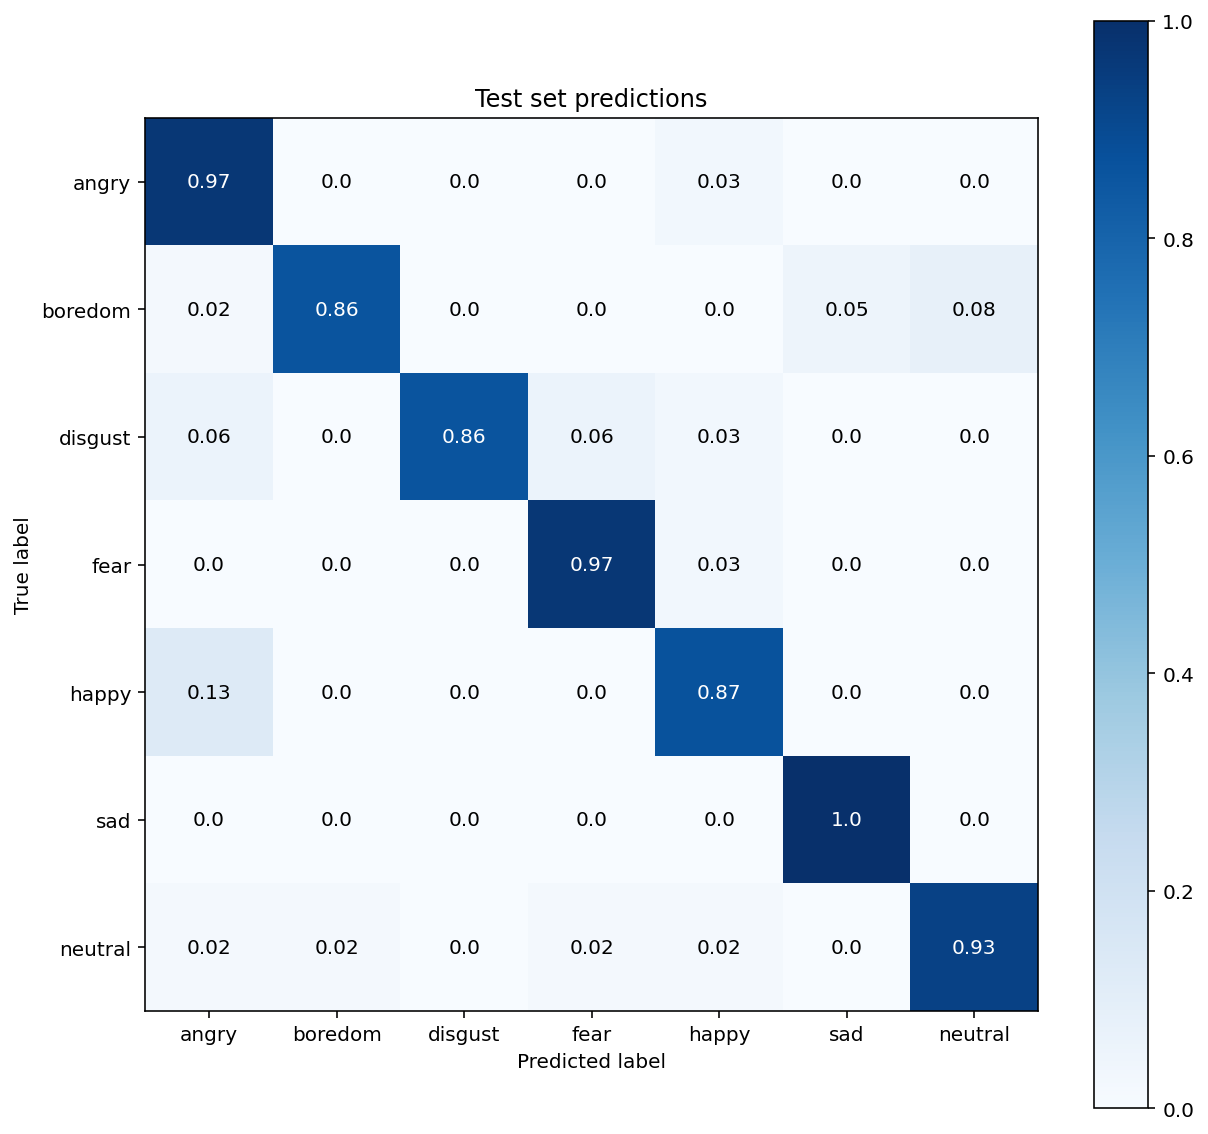

In [86]:
X, y = get_dataset(augment=True, n_modifications=3)
X_train, X_test, y_train, y_test = create_train_test_sets(X, y, test_size=0.2, random_state=1, shuffle=True)

model = network_model()
scores_train, scores_test, history = run_best_model_or_train_model(model, X_train, X_test, y_train, y_test,
                                                                   force_train=False, num_epoch=10, 
                                                                   save_history=False, pretrained=True)

print("Displaying confusion matrix")
plot_emotion_confusion_matrix(model, X_test, y_test)

The model is able to distinguish between all 7 utterances. It might find sometimes hard to distinguish between angry-happy, angry-disgust, fear-disgust, sad-boredom, neutral-boredom.


## Prediciton Pipeline

To predict an audio sample query the predict endpoint without any argument:

In [87]:
!curl "http://localhost:5000/predict"

{
  "0": "16a02Lb.wav", 
  "1": "14a07Wc.wav", 
  "2": "10a07Ad.wav", 
  "3": "13a05Ea.wav", 
  "4": "14a05Wa.wav", 
  "5": "14a07Na.wav", 
  "6": "15a05Wa.wav", 
  "7": "16b10Wb.wav", 
  "8": "09a01Nb.wav", 
  "9": "16a01Fc.wav", 
  "10": "14a04Ed.wav", 
  "11": "11a01Ab.wav", 
  "12": "09b02Na.wav", 
  "13": "03a05Nd.wav", 
  "14": "10a01Ac.wav", 
  "15": "16a04Ab.wav", 
  "16": "15b02Nd.wav", 
  "17": "16b09Wb.wav", 
  "18": "11a01Ld.wav", 
  "19": "08a01Wa.wav", 
  "20": "09b02Wc.wav", 
  "21": "12b09Td.wav", 
  "22": "10b02Aa.wav", 
  "23": "16a04Tc.wav", 
  "24": "16b01La.wav", 
  "25": "13b01Wa.wav", 
  "26": "12b01Wa.wav", 
  "27": "13b03Na.wav", 
  "28": "12a02Wc.wav", 
  "29": "16b03Ad.wav", 
  "30": "13b03Wc.wav", 
  "31": "13b01Nc.wav", 
  "32": "15a02Ea.wav", 
  "33": "11a05Td.wav", 
  "34": "14a02Ea.wav", 
  "35": "09b03Ed.wav", 
  "36": "13a02Wa.wav", 
  "37": "16b03La.wav", 
  "38": "12a02Wa.wav", 
  "39": "13b10La.wav", 
  "40": "03b02Wb.wav", 
  "41": "13a02Nc.wav", 


Select an ID from 0 to 534 and pass it as an argument of the predict query. For example, to predict 14a07Na.wav query the following 

In [88]:
!curl "http://localhost:5000/predict?ID=5"

{
  "Audio file": "data/wav/14a07Na.wav", 
  "Class probabilities": "{'angry': 5.3010273e-11, 'boredom': 5.616377e-05, 'disgust': 6.1022307e-09, 'fear': 3.9480906e-08, 'happy': 1.3807703e-08, 'sad': 0.007886225, 'neutral': 0.9920575}", 
  "Predicted emotion is": "neutral", 
  "True emotion is": "neutral", 
  "Used the optimized best model": true
}


Beware of using the correct argument:

In [90]:
!curl "http://localhost:5000/predict?ID=-5"

{
  "Error:": [
    "Sample must be in range(0,535)"
  ]
}


## Conclusions

This model has been successfully implemented and a general user could set the app.py parameters in order to fully train a model from scratch, using or not augmented data, and predict from that new model. 

I believe more effort could be spent in understanding the data and getting better parameters for the feature extraction and augmentation steps. 

More effort can be spent also in optimizing the api code. Data_reader and network_model modules can be wrapped in classes making the code more elegant and clear. The api routes (expecially the train endpoint) can be extended to accept parameters to setup the model without inspecting the code. 

Overall the project achieved its goal. 
Ready to submit.
